# Basic Within-Subject Experiment on the ExtraSensory data set

## Set up the Notebook

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import importlib, sys, os
sys.path.insert(0, os.path.abspath('..'))
if(importlib.util.find_spec("mFlow") is None):
    !git clone https://github.com/mlds-lab/mFlow.git
    !pip install ./mFlow
else:
    print("mFlow module found")

mFlow module found


## Import modules

In [5]:
from mFlow.Blocks.data_loader_extrasensory import extrasensory_data_loader
from mFlow.Blocks.filter import MisingLabelFilter,  MisingDataColumnFilter, Take
from mFlow.Blocks.imputer import Imputer
from mFlow.Blocks.normalizer import Normalizer
from mFlow.Blocks.experimental_protocol import ExpTrainTest, ExpCV, ExpWithin
from mFlow.Blocks.results_analysis import ResultsConcat, ResultsCVSummarize, DataYieldReport
from mFlow.Workflow.workflow import workflow
import mFlow.Workflow.compute_graph

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score 
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt


## Define the workflow

This workflow performs a within-subject experiment on the ExtraSensory data set sleeping prediction task using a subset of the first 50,000 instances. The model used is logistic regression with a fixed regularization hyper-parameter. 

The workflow includes a column filter that screens out feature dimensions that are less than 20% observed, and a missing label filter that removes instances without labels. Next, the workflow performs mean imputation followed by feature normalization. At this point, a data yield report is added to the workflow and the worflow is executed to determine the number of individuals in the pre-processed data set. Finally, the within subject experiment with result summarization is added to the workflow and the newly added steps are executed.

The workflow computation graph is then created and displayed along with the results. 

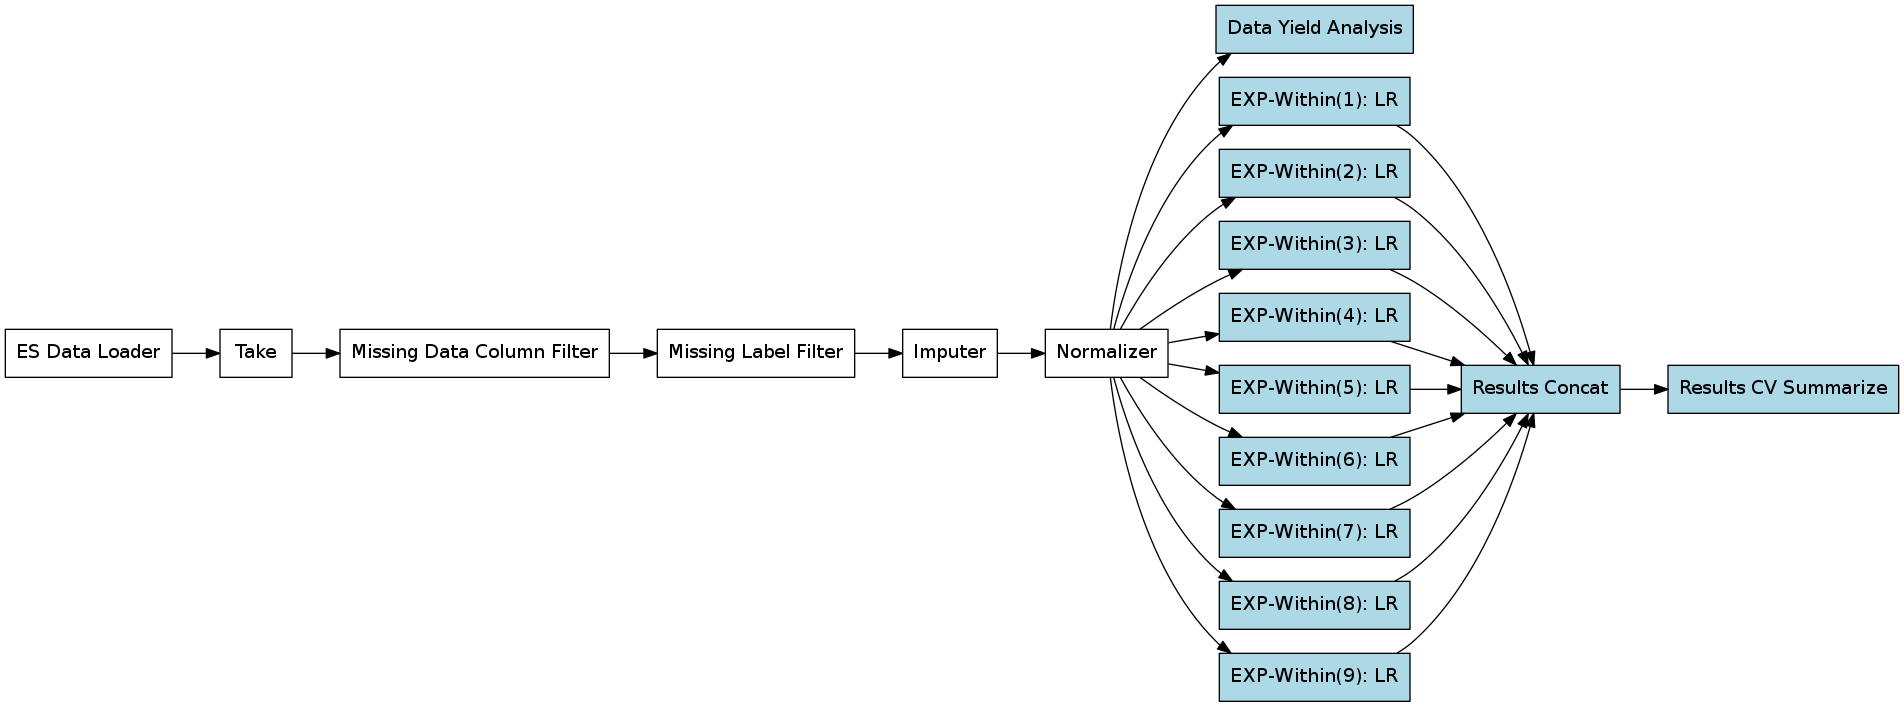

In [18]:
estimators = {"LR": LogisticRegression(solver="lbfgs",max_iter=100)}

metrics   = [accuracy_score, f1_score, precision_score, recall_score]
df_raw    = extrasensory_data_loader(label="SLEEPING");
df_sub    = Take(df_raw, 50000)
df_cf     = MisingDataColumnFilter(df_sub)
df_lf     = MisingLabelFilter(df_cf)
df_imp    = Imputer(df_lf)
df_norm   = Normalizer(df_imp)
report    = DataYieldReport(df_norm, names=["Norm"])

flow      = workflow({"yield":report})
output    = flow.run(monitor=True)
num       = output['yield']['report']["#Individuals with Data"]["Norm"]

res_within= ExpWithin(df_norm, estimators, metrics=metrics, n_folds=num);
res_cat   = ResultsConcat(res_within)
res       = ResultsCVSummarize(res_cat)
flow.add_output(res,"results")

flow.draw()
output=flow.run(monitor=True)


In [8]:
output["results"]["report"]

accuracy_score            f1_score           precision_score            \
                 mean       sem      mean       sem            mean       sem   
Method                                                                          
LR           0.825149  0.065134  0.506411  0.160194        0.609404  0.133766   

       recall_score            
               mean       sem  
Method                         
LR         0.510654  0.164866